In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action='ignore')

## dataset

In [2]:
ratebeer = pd.read_json("./data/new_ratebeer.json", lines=True).dropna()

In [3]:
ratebeer.tail()

,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text
2924158,Oakhill Mendip Twister,12240,1028.0,6.3,Stout,3/5,7/10,3/5,7/10,15/20,1.013731e+09,rauchbier,"Doesnt suggest it from the bottle label, but f..."
2924159,Oakhill Yeoman 1767 Strong Ale,5677,1028.0,5,Premium Bitter/ESB,4/5,5/10,3/5,6/10,12/20,1.074816e+09,imdownthepub,"Cask conditioned at The Wild Goose, Combeignte..."
2924160,Oakhill Yeoman 1767 Strong Ale,5677,1028.0,5,Premium Bitter/ESB,4/5,4/10,3/5,6/10,13/20,1.050797e+09,SilkTork,The original Oakhill Brewery was formed in 176...
2924161,Oakhill Yeoman 1767 Strong Ale,5677,1028.0,5,Premium Bitter/ESB,3/5,5/10,2/5,5/10,10/20,1.016410e+09,omhper,Sampled cask conditioned. Amber coloured. Frui...
2924162,Oakhill Yeoman 1767 Strong Ale,5677,1028.0,5,Premium Bitter/ESB,4/5,8/10,4/5,7/10,15/20,1.000253e+09,Bov,


In [4]:
ratebeer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2924163 entries, 0 to 2924162
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   beer/name           object 
 1   beer/beerId         object 
 2   beer/brewerId       float64
 3   beer/ABV            object 
 4   beer/style          object 
 5   review/appearance   object 
 6   review/aroma        object 
 7   review/palate       object 
 8   review/taste        object 
 9   review/overall      object 
 10  review/time         float64
 11  review/profileName  object 
 12  review/text         object 
dtypes: float64(2), object(11)
memory usage: 312.3+ MB


### 편의점 유통 맥주만 가져오기

In [5]:
# 편의점 유통 맥주 리스트 csv
kor_beer_list_csv = pd.read_csv("./data/ratebeer_list_inKorea.csv",header=None, names = ['name', 'id', 'review_count'])

# 결측치 처리
kor_beer_list_csv['review_count'].fillna(0, inplace = True)
# id 타입 변환(기존 데이터와 통일)
kor_beer_list_csv['id'] = kor_beer_list_csv['id'].astype(str)

In [6]:
# 편의점 유통 맥주 list
kor_beer_list = kor_beer_list_csv['id'].unique()
len(kor_beer_list)

97

In [7]:
# 전체 데이터에서 한국 편의점 맥주만 추출
ratebeer_kor = ratebeer[ratebeer['beer/beerId'].isin(kor_beer_list)].reset_index(drop = True)
ratebeer_kor

,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text
0,Eichbaum Apostel Bru,75661,1103.0,4.8,Classic German Pilsener,3/5,6/10,3/5,6/10,15/20,1.324685e+09,Leighton,"Can in Gabrovo, Bulgaria, at 5%. Pours clear, ..."
1,Eichbaum Apostel Bru,75661,1103.0,4.8,Classic German Pilsener,3/5,4/10,2/5,3/10,7/20,1.324080e+09,oh6gdx,Canned (thanks CueSheet). Yellowish golden col...
2,Eichbaum Apostel Bru,75661,1103.0,4.8,Classic German Pilsener,2/5,3/10,2/5,3/10,7/20,1.324080e+09,TBone,"Can 330ml (ABV 5.0 %, BB 06/2012)\tGolden colo..."
3,Eichbaum Apostel Bru,75661,1103.0,4.8,Classic German Pilsener,3/5,5/10,3/5,5/10,10/20,1.322438e+09,blankboy,Can [330ml].Pours a clear bubbly light gold wi...
4,Eichbaum Apostel Bru,75661,1103.0,4.8,Classic German Pilsener,3/5,3/10,3/5,4/10,10/20,1.316736e+09,suurjuust,"Clear pale yellow, white head. Aroma of cereal..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45066,Krombacher Weizen,71469,581.0,5.3,German Hefeweizen,4/5,6/10,3/5,6/10,11/20,1.274141e+09,YK23,"Bottle: bubblegum, wheat, lots of banana, some..."
45067,Krombacher Weizen,71469,581.0,5.3,German Hefeweizen,3/5,5/10,3/5,5/10,9/20,1.272067e+09,Zita,"weat,bread,amber, hazy, white foam, light swee..."
45068,Krombacher Weizen,71469,581.0,5.3,German Hefeweizen,4/5,6/10,4/5,7/10,14/20,1.270944e+09,johndoughty,Bottle. Lively on opening with a large head. ...
45069,Krombacher Weizen,71469,581.0,5.3,German Hefeweizen,4/5,9/10,4/5,7/10,14/20,1.262995e+09,turbothy,Pours hazy light amber with medium head. Very ...


In [8]:
# 전체 데이터에서 한국 편의점 맥주 개수
len(ratebeer_kor['beer/name'].unique())

49

### preprocessing

In [9]:
def preprocessing_df(df):
    # rating 전처리
    df['rating/apperance'] = df['review/appearance'].str.split("/").str[0].astype(int)
    df['rating/aroma'] = df['review/aroma'].str.split("/").str[0].astype(int)
    df['rating/palate'] = df['review/palate'].str.split("/").str[0].astype(int)
    df['rating/taste'] = df['review/taste'].str.split("/").str[0].astype(int)
    df['rating/overall'] = df['review/overall'].str.split("/").str[0].astype(int)
    
    # overall rating 최대치 5로 변환
    df['rating/overall'] = df['rating/overall'] / 20 * 5
    
    # item, user, rating만 추출
    df = df[['beer/beerId', 'review/profileName', 'rating/overall']]
    df.rename(columns={'beer/beerId' : 'item_id', 'review/profileName' : 'user', 'rating/overall' : 'rating'}, inplace = True) 
    
    # 유저 리뷰 수 개산
    df['user/reviewcount'] = df.groupby('user')['user'].transform('count')
    # 리뷰 수가 10개 이상인 유저만 남김 
    df = df[(df['user/reviewcount'] > 10)]
    
    df.drop(columns=['user/reviewcount'], inplace=True)
    
    num_users = df.user.unique().shape[0]
    num_items = df.item_id.unique().shape[0]
    return df, num_users, num_items

### Statistics of the Dataset

In [10]:
data, num_users, num_items = preprocessing_df(ratebeer_kor)
sparsity = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head())

number of users: 1360, number of items: 49
matrix sparsity: 0.645573
  item_id            user  rating
0   75661        Leighton    3.75
1   75661          oh6gdx    1.75
2   75661           TBone    1.75
3   75661        blankboy    2.50
7   75661  Koelschtrinker    1.75


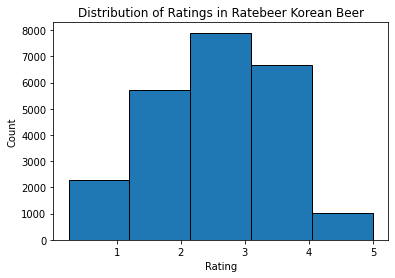

In [11]:
plt.hist(data['rating'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in Ratebeer Korean Beer')
plt.show()

### Label Encoding

In [12]:
user_le = LabelEncoder()
item_le = LabelEncoder()
data['user_id_idx'] = user_le.fit_transform(data['user'].values)
data['item_id_idx'] = item_le.fit_transform(data['item_id'].values)

data.drop(columns=['user', 'item_id'], inplace=True)

### Loading the data

In [13]:
class BeerDataset(Dataset):
    def __init__(self, df, mode='train'):
        self.df = df
        self.mode = mode
        self.train_size = 0.8
        self.val_size = 0.1
        self.test_size = 1 - self.train_size - self.val_size 

        self.num_items = len(self.df['item_id_idx'].unique())
        self.num_users = len(self.df['user_id_idx'].unique())
        
        n_val = int(self.num_users * self.val_size)
        n_test = int(self.num_users * self.test_size)
        
        random.seed(42)
        
        val_indices = set(random.choices(range(self.num_users), k=n_val))
        test_indices = set(random.choices(list(set(range(self.num_users)) - val_indices), k=n_test))
        train_indices = set(range(self.num_users)) - val_indices - test_indices
    
        # self.train_df, self.test_df = train_test_split(self.df, test_size=self.test_size, train_size=self.train_size, stratify = self.df['user_id_idx'].values, random_state=42)
                        
        if self.mode == 'train':
            self.df = self.df[self.df['user_id_idx'].isin(train_indices)]
        elif self.mode == 'val':
            self.df = self.df[self.df['user_id_idx'].isin(val_indices)]
        else:
            self.df = self.df[self.df['user_id_idx'].isin(test_indices)]

        self.users = torch.tensor(self.df['user_id_idx'].values)
        self.items = torch.tensor(self.df['item_id_idx'].values)
        self.ratings = torch.tensor(self.df['rating'].values)
        
        self.inter_mat = self.make_inter_mat()
    
    def make_inter_mat(self):
        inter_mat = np.zeros((self.num_users, self.num_items))
        for user, item, rating in zip(self.users, self.items, self.ratings):
            inter_mat[user][item] = rating

        return inter_mat

    def __len__(self):
        return len(self.inter_mat)

    def __getitem__(self, index):
        inter_mat = torch.tensor(self.inter_mat[index]).float()

        return index, inter_mat

### Autorec Model

In [14]:
class AutoRec(nn.Module):
    def __init__(self, num_hidden, num_items, dropout=0.05):
        super(AutoRec, self).__init__()
        self.encoder = nn.Linear(num_items, num_hidden)
        self.sigmoid = nn.Sigmoid()
        self.decoder = nn.Linear(num_hidden, num_items)
        self.dropout = nn.Dropout(dropout)

    def forward(self, mat):
        hidden = self.dropout(self.sigmoid(self.encoder(mat)))
        pred = self.decoder(hidden)
        
        return pred

###  Model train, validcation

In [15]:
def train(model, train_iter, criterion, optm, device):
    model.train() # to train mode
    loss_sum = 0

    for _, inter_mat in train_iter:
        inter_mat = inter_mat.to(device)    

        preds = model(inter_mat)
        loss = criterion(preds, inter_mat)

        # Update
        optm.zero_grad()      # reset gradient 
        loss.backward()      # backpropagate
        optm.step()      # optimizer update
        
        loss_sum += loss.item()
        
    loss_avg = loss_sum / len(train_iter)

    return loss_avg

In [16]:
def validation(model, valid_iter, criterion, device):
    with torch.no_grad():
        model.eval()
        loss_sum = 0

        for _, inter_mat in valid_iter:
            inter_mat = inter_mat.to(device) 

            preds = model(inter_mat)
            loss = criterion(preds, inter_mat)            

            loss_sum += loss.item()

    loss_avg = loss_sum / len(valid_iter)

    return loss_avg

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 25
lr = 0.001
batch_size = 64

num_items = data.item_id_idx.nunique()
num_hidden = 100

In [18]:
train_dataset = BeerDataset(df=data, mode='train')
val_dataset = BeerDataset(df=data, mode='val')

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) 
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [19]:
model = AutoRec(num_hidden, num_items).to(device)
loss = nn.MSELoss()
optm = optim.Adam(model.parameters(),lr=lr)

epoch: 0, train Loss: 1.5886, test Loss: 0.5463
epoch: 1, train Loss: 1.0269, test Loss: 0.6579
epoch: 2, train Loss: 0.9407, test Loss: 0.5502
epoch: 3, train Loss: 0.8968, test Loss: 0.4762
epoch: 4, train Loss: 0.8591, test Loss: 0.4187
epoch: 5, train Loss: 0.8272, test Loss: 0.3849
epoch: 6, train Loss: 0.7910, test Loss: 0.3411
epoch: 7, train Loss: 0.7635, test Loss: 0.3096
epoch: 8, train Loss: 0.7218, test Loss: 0.2760
epoch: 9, train Loss: 0.6820, test Loss: 0.2516
epoch: 10, train Loss: 0.6561, test Loss: 0.2206
epoch: 11, train Loss: 0.6235, test Loss: 0.2007
epoch: 12, train Loss: 0.5900, test Loss: 0.1775
epoch: 13, train Loss: 0.5630, test Loss: 0.1593
epoch: 14, train Loss: 0.5420, test Loss: 0.1440
epoch: 15, train Loss: 0.5169, test Loss: 0.1294
epoch: 16, train Loss: 0.4871, test Loss: 0.1191
epoch: 17, train Loss: 0.4750, test Loss: 0.1073
epoch: 18, train Loss: 0.4502, test Loss: 0.0997
epoch: 19, train Loss: 0.4349, test Loss: 0.0902
epoch: 20, train Loss: 0.4165,

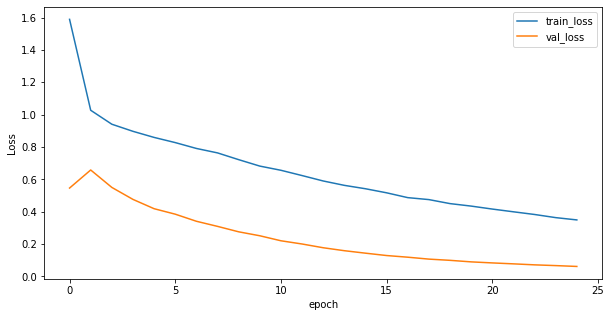

In [20]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    train_loss = train(model, train_dataloader, loss, optm, device)
    val_loss = validation(model, val_dataloader, loss, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'epoch: {epoch}, train Loss: {train_loss:.4f}, test Loss: {val_loss:.4f}')

plt.figure(figsize=(10,5))
plt.plot(train_losses,label="train_loss")
plt.plot(val_losses,label="val_loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [21]:
PATH = './model/autorec.pt'
torch.save(model.state_dict(), PATH)

### inference

In [22]:
model = AutoRec(num_hidden, num_items).to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [23]:
def ndcg_k(actual, predicted, topk):
    res = 0
    for user_id in range(len(actual)):
        k = min(topk, len(actual[user_id]))
        idcg = idcg_k(k)
        dcg_k = sum(
            [
                int(predicted[user_id][j] in set(actual[user_id])) / math.log(j + 2, 2)
                for j in range(topk)
            ]
        )
        res += dcg_k / idcg
    return res / float(len(actual))

# Calculates the ideal discounted cumulative gain at k
def idcg_k(k):
    res = sum([1.0 / math.log(i + 2, 2) for i in range(k)])
    if not res:
        return 1.0
    else:
        return res

def recall_at_k(actual, predicted, topk):
    sum_recall = 0.0
    num_users = len(predicted)
    true_users = 0
    for i in range(num_users):
        act_set = set(actual[i])
        pred_set = set(predicted[i][:topk])
        if len(act_set) != 0:
            sum_recall += len(act_set & pred_set) / float(len(act_set))
            true_users += 1
    return sum_recall / true_users

In [24]:
def inference(model, test_iter, test_matrix, device, topk = 4):
    pred_list = None
    answer_list = None
    with torch.no_grad():
        model.eval()

        for i, (user_ids, inter_mat) in enumerate(test_iter):
            inter_mat = inter_mat.to(device)
            
            rating_pred = model(inter_mat)
            
            rating_pred = rating_pred.cpu().data.numpy().copy()
            
            batch_user_index = user_ids.cpu().numpy()
            answers = test_matrix.argsort(axis = 1)[batch_user_index, -topk:]
            # rating_pred[test_matrix[batch_user_index] > 0] = 0
            
            ind = np.argpartition(rating_pred, -topk)[:, -topk:]
            
            arr_ind = rating_pred[np.arange(len(rating_pred))[:, None], ind]

            arr_ind_argsort = np.argsort(arr_ind)[np.arange(len(rating_pred)), ::-1]

            batch_pred_list = ind[
                np.arange(len(rating_pred))[:, None], arr_ind_argsort
            ]

            if i == 0:
                pred_list = batch_pred_list
                answer_list = answers
            else:
                pred_list = np.append(pred_list, batch_pred_list, axis=0)
                answer_list = np.append(
                        answer_list, answers, axis=0
                )
            
        recall = recall_at_k(answer_list, pred_list, topk)
        ndcg = ndcg_k(answer_list, pred_list, topk)
        
        print(f'recall@{topk} = {recall}, ndcg@{topk} = {ndcg}')
    return pred_list, answer_list

In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 25
lr = 0.001
batch_size = 64

num_items = data.item_id_idx.nunique()
num_hidden = 100

In [26]:
test_dataset = BeerDataset(df=data, mode='test')

test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

test_matrix = test_dataset.inter_mat

In [27]:
pred_list, answer_list = inference(model, test_dataloader, test_matrix, device, topk=4)

recall@4 = 0.28823529411764703, ndcg@4 = 0.4197270140080918


In [28]:
test_dataset.df.user_id_idx.unique()

array([ 368, 1359, 1352,  661, 1135,  111, 1133,  253,  843,  626,   99,
       1185,  832, 1198,  338,  613,  216, 1023,  414,   72,  916,  580,
       1269,  894,   81,  167,  169,  288, 1358, 1258,  553,  913,  437,
        575,  995,   96,  468, 1302,  432,  183,  551,  343,  136,  324,
        508, 1196,  637,   11,  802,  277,  709,  259,  738,   82, 1306,
        749,  703,  579, 1341,  318,  581,  796,  644,  139,  976,  308,
       1338,  918, 1019,  960,  315,  327,  778,  367, 1337, 1153,  178,
        621,  212,  978, 1041, 1158, 1270,  467, 1110,   98,  273, 1169,
        888,  291,  545,  100,  735, 1066,  809, 1316, 1254,  227,  794,
        683,  647,  101,  522, 1353, 1231,  858, 1166, 1096, 1034, 1210,
        600,  810,  301,  994,  410,  386,  290,  590,  606,  758, 1268,
        921,  789,  341,  328])

In [29]:
pred_list[368]

array([33,  1, 23, 14])

In [30]:
answer_list[368]

array([48,  1, 22,  2])

In [31]:
test_matrix[368]

array([0.  , 4.25, 4.75, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 2.  , 3.75, 3.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       4.5 , 3.75, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       4.  , 0.  , 3.75, 0.  , 0.  , 0.  , 3.75, 0.  , 0.  , 0.  , 0.  ,
       2.5 , 0.  , 3.75, 0.  , 4.  ])